# Explainability in Machine Learning - Clinical Records Analysis

## Problem Statement

Cardiovascular diseases (CVDs) remain a major health concern worldwide, causing the deaths of approximately 17 million people annually. Among these, heart failure (HF) is particularly notable, occurring when the heart cannot pump sufficient blood to meet the body's needs. HF is often a consequence of conditions such as diabetes and high blood pressure. Clinically, heart failure is categorized into two types based on the ejection fraction: heart failure with reduced ejection fraction (HFrEF) and heart failure with preserved ejection fraction (HFpEF). Despite advances in medical research, predicting survival outcomes for heart failure patients and identifying critical predictive factors remains challenging.

The explainability of machine learning models is crucial in healthcare, where the consequences of model misinterpretation can be severe. This case study evaluates the explainability of machine learning models in predicting the survival of heart failure patients. The dataset used in this study contains 299 patient records, each with 10 clinical features and a target variable indicating patient survival.

In this case study, we evaluate explainability in clinical records of hearth failure. We use the dataset available in [UCI Repository](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records). 

In [1]:
from holisticai.datasets import load_dataset

dataset = load_dataset('clinical_records')
dataset

Dataset({
        features: ['X', 'y', 'group_a', 'group_b'],
        num_rows: 299
    })

## Data analysis

The dataset analyzed in this study consists of medical records of 299 heart failure patients collected from the Faisalabad Institute of Cardiology and Allied Hospital in Faisalabad, Pakistan, during April-December 2015. The cohort includes 105 women and 194 men, aged between 40 and 95 years, all of whom had left ventricular systolic dysfunction and previous heart failures classified as class III or IV by the New York Heart Association (NYHA).

In [2]:
print(dataset.data.info())
print('Number of deaths:', dataset['y'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   (X, anaemia)                   299 non-null    int64  
 1   (X, creatinine_phosphokinase)  299 non-null    int64  
 2   (X, diabetes)                  299 non-null    int64  
 3   (X, ejection_fraction)         299 non-null    int64  
 4   (X, high_blood_pressure)       299 non-null    int64  
 5   (X, platelets)                 299 non-null    float64
 6   (X, serum_creatinine)          299 non-null    float64
 7   (X, serum_sodium)              299 non-null    int64  
 8   (X, smoking)                   299 non-null    int64  
 9   (X, time)                      299 non-null    int64  
 10  (y, y)                         299 non-null    int64  
 11  (group_a, group_a)             299 non-null    bool   
 12  (group_b, group_b)             299 non-null    boo

In table above, we observe that the dataset contains 10 features and 1 target variable. The features include both numerical and categorical variables. The target variable, `DEATH_EVENT`, is binary and indicates whether the patient died during the follow-up period (1) or survived (0). The dataset is imbalanced, with 203 patients surviving and 96 patients dying during the follow-up period.

- **Categorical features**

    - anaemia: Presence of anemia (0 = no, 1 = yes)
    - high_blood_pressure: Presence of hypertension (0 = no, 1 = yes)
    - creatinine_phosphokinase (CPK): Level of the CPK enzyme in the blood (mcg/L)
    - diabetes: Presence of diabetes (0 = no, 1 = yes)
    - ejection_fraction: Percentage of blood leaving the heart at each contraction
    - serum_sodium: Sodium level in the blood (mEq/L)
    - smoking: Whether the patient is a smoker (0 = no, 1 = yes)

- **Numerical features**

    - serum_creatinine: Level of creatinine in the blood (mg/dL)
    - platelets: Platelet count (kiloplatelets/mL)
    - time: Follow-up period (days)

- **Target variable**

    - y: Whether the patient died during the follow-up period (0 = no, 1 = yes)

<Axes: xlabel='subfeatures', ylabel='subfeatures'>

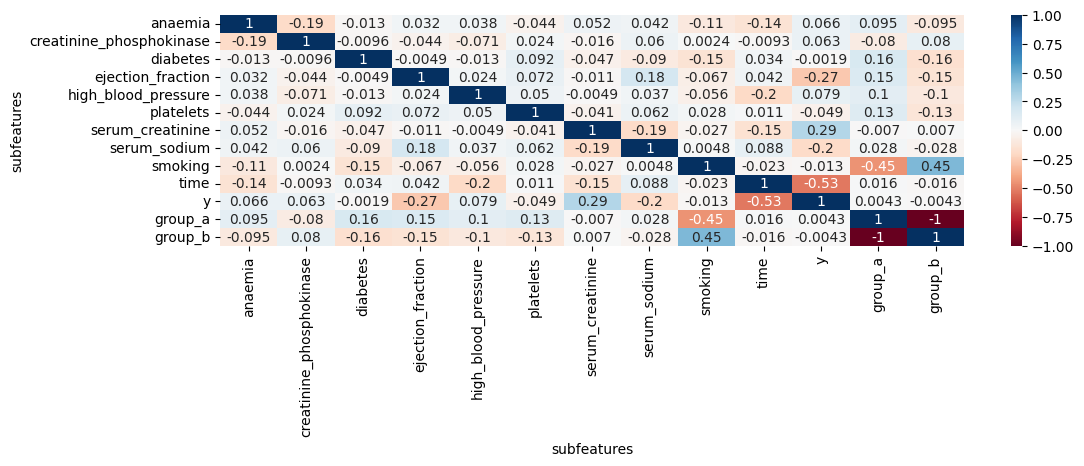

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 3))
sns.heatmap(dataset.data.droplevel('features', axis=1).corr(), annot=True, cmap='RdBu')

The correlation matrix shows that the most correlated features with the target variable are `serum_creatinine`, `ejection_fraction`, and `time`. The "follow-up time" refers to the duration of time that patients are monitored after an initial event, diagnosis, treatment, or enrollment in a study. This period is crucial for assessing the long-term outcomes and effectiveness of treatments, as well as for observing the progression of the disease and any potential complications.

So, we can expect that these features will have a significant impact on the prediction of the target variable.

## Explainability Metrics

### Model`s predictions

First, we will implment a Logistic Regression model to predict the target variable and compute the accuracy of the model. We will also evaluate the model's performance using the confusion matrix, precision, recall, and F1 score.

In [4]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

data = dataset.train_test_split(test_size=0.2, random_state=42)
train = data['train']
test = data['test']

model = LogisticRegression()
model.fit(train['X'], train['y'])

print(classification_report(test['y'], model.predict(test['X'])))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85        35
           1       0.88      0.60      0.71        25

    accuracy                           0.80        60
   macro avg       0.82      0.77      0.78        60
weighted avg       0.82      0.80      0.79        60



We can observe that the model has an accuracy of 0.81, which is quite good. However, we can see that the model has a higher recall for the negative class (0) than for the positive class (1). This indicates that the model is better at predicting the survival of patients than predicting the death of patients.

Let's now measure the explainability of the model using different global and local explainability metrics.

### Permutation feature importance metrics

In [5]:
from holisticai.explainability.metrics import classification_explainability_features
from holisticai.explainability.metrics import compute_explainability_metrics_from_features

xai_features = classification_explainability_features(test['X'], test['y'], model.predict, model.predict_proba, classes=model.classes_, strategy="permutation")

compute_explainability_metrics_from_features(xai_features)

,value,reference
metric,,
Alpha Importance Score,0.100000,0.0
XAI Ease Score,1.000000,1.0
Position Parity,1.000000,1.0
Rank Alignment,1.000000,1.0
Spread Ratio,0.313401,0.0


The metrics used to evaluate the feature importance indicates that:

- Alpha importance score: fewer features have high importance values, suggesting a more even distribution of feature importance.

- XAI ease score: simple, linear relationship between the feature and the predicted outcome. These curves are easy to interpret.

- Position parity: high consistency in the order of feature importance between the overall and conditional feature importance, suggesting that the model behaves similarly across different groups.

- Rank alignment: a high overlap in the top-k feature importance rankings between the overall and conditional feature importance, suggesting that the model's feature importance is consistent across different groups.

- Spread ratio: the distribution of feature importance is far from uniform, suggesting that the model relies on fewer, more significant features. This implies higher interpretability.

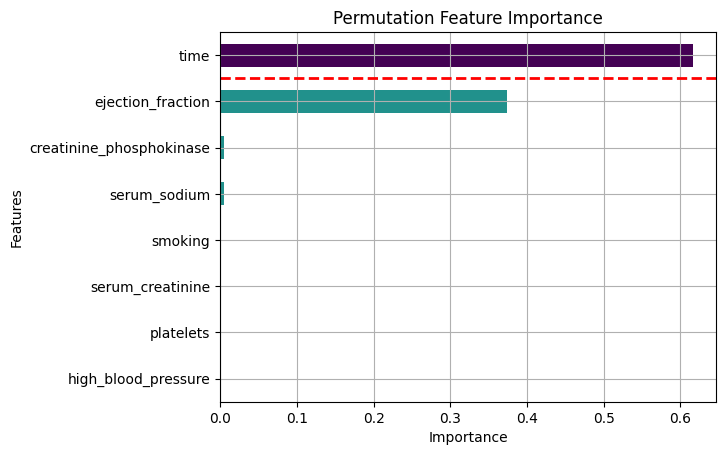

In [6]:
from holisticai.explainability.plots import plot_feature_importance

plot_feature_importance(xai_features.feature_importance, xai_features.ranked_feature_importance, top_n=8)

In this feature importance plot we can observe that the most important features are time and ejection fraction, which are partially consistent with the correlation matrix.

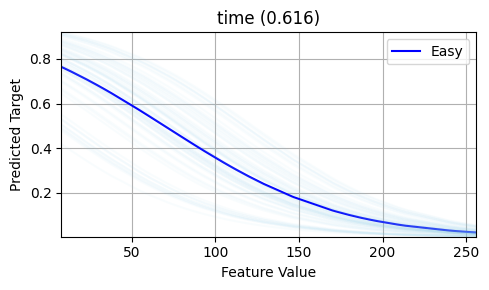

In [7]:
from holisticai.explainability.plots import plot_partial_dependence

# class 1
class_index = 1
plot_partial_dependence(xai_features.partial_dependence[class_index], xai_features.ranked_feature_importance, figsize=(5, 3))

The partial dependence plot for target class 1 shows a negative relationship with feature `time`, indicating that as the follow-up time increases, the probability of death decreases. This is consistent with the correlation matrix, where `time` was negatively correlated with the target variable. Following, we can observe positive relationship the class 0 and the feature `time`, indicating that as the follow-up time increases, the probability of survival increases.

The monotonic behaviour of the partial dependence plot suggests that the model is ease to interpret, as shown but the XAI ease score metric.

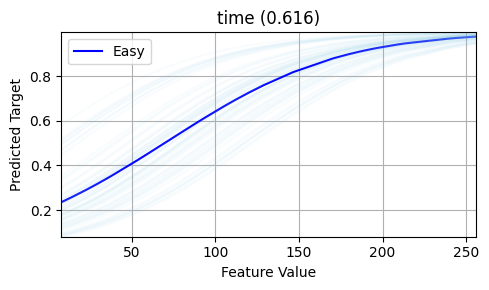

In [8]:
# class 1
class_index = 0
plot_partial_dependence(xai_features.partial_dependence[class_index], xai_features.ranked_feature_importance, figsize=(5, 3))

### Surrogate metrics

In [9]:
xai_features = classification_explainability_features(test['X'], test['y'], model.predict, model.predict_proba, classes=model.classes_, strategy="surrogate")

compute_explainability_metrics_from_features(xai_features)

,value,reference
metric,,
Alpha Importance Score,0.100000,0.0
XAI Ease Score,1.000000,1.0
Position Parity,1.000000,1.0
Rank Alignment,1.000000,1.0
Spread Ratio,0.281941,0.0


For surrogate, the interpretation of metric scores is similar to the permutation feature importance. But, we can plot the surrogate model to visualize the relationship between the features and the predicted outcome.

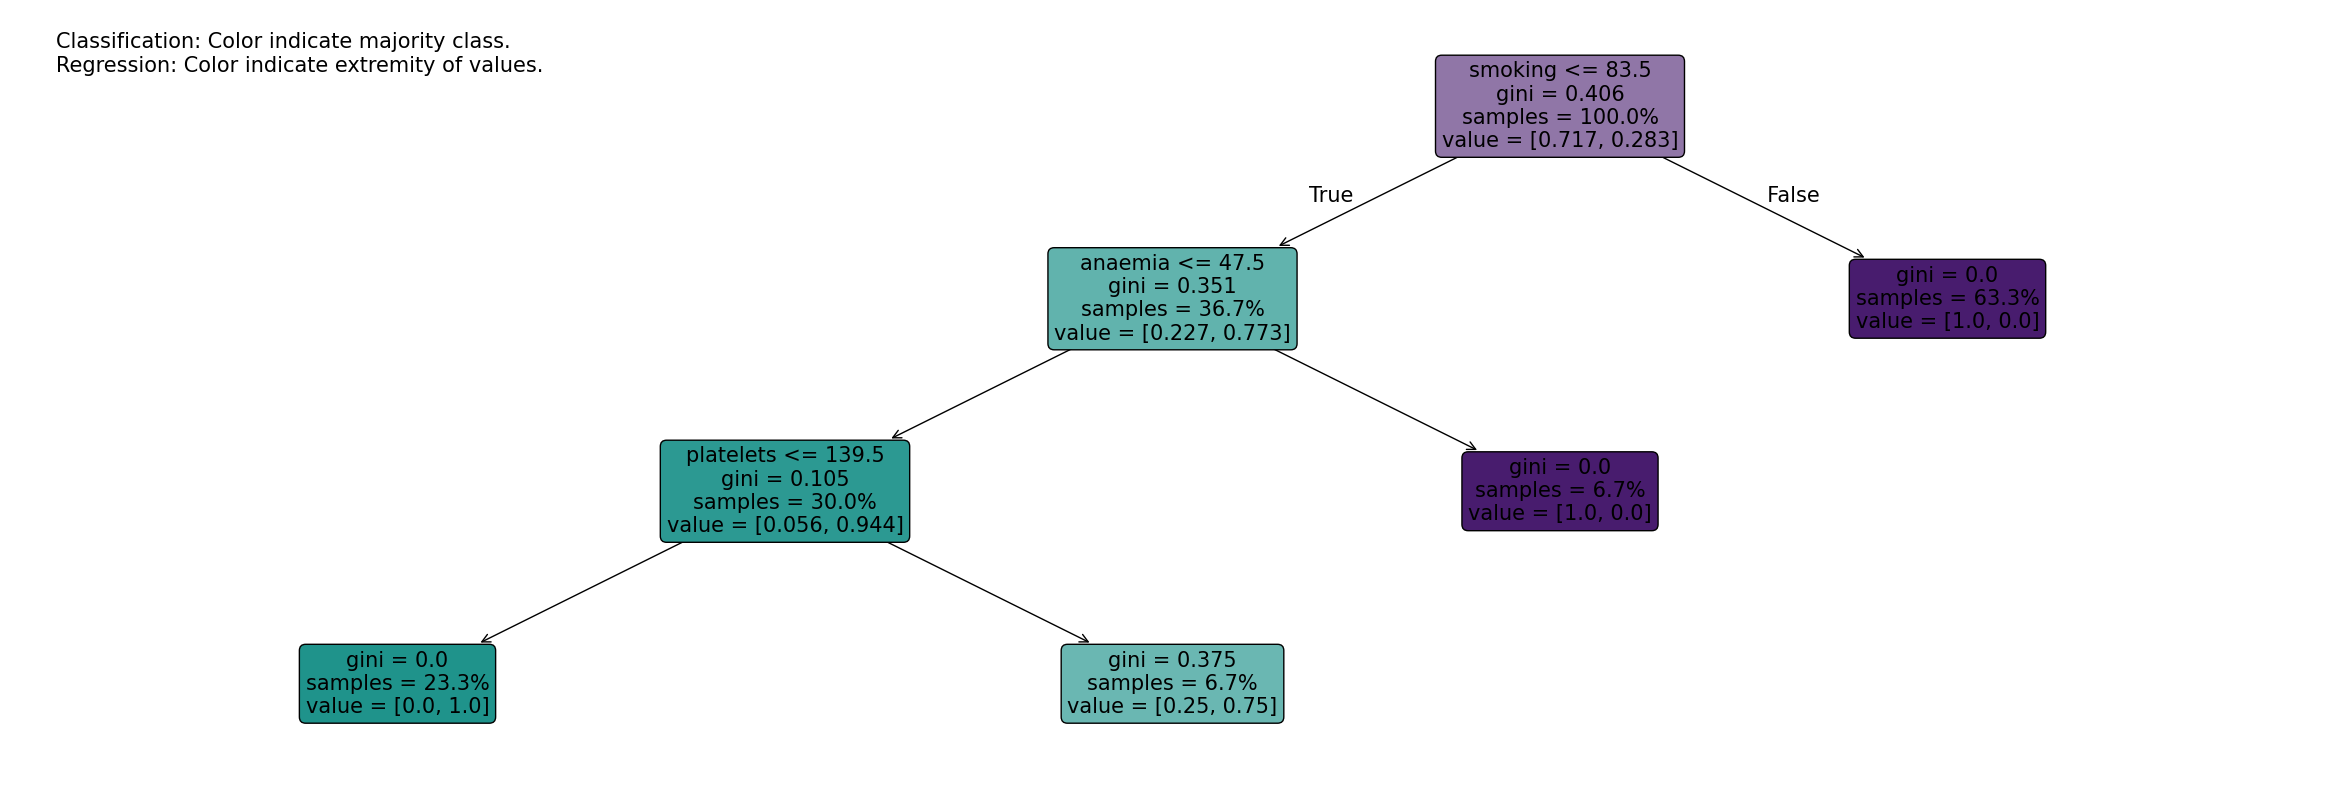

In [10]:
from holisticai.explainability.plots import plot_surrogate

plot_surrogate(xai_features.feature_importance)

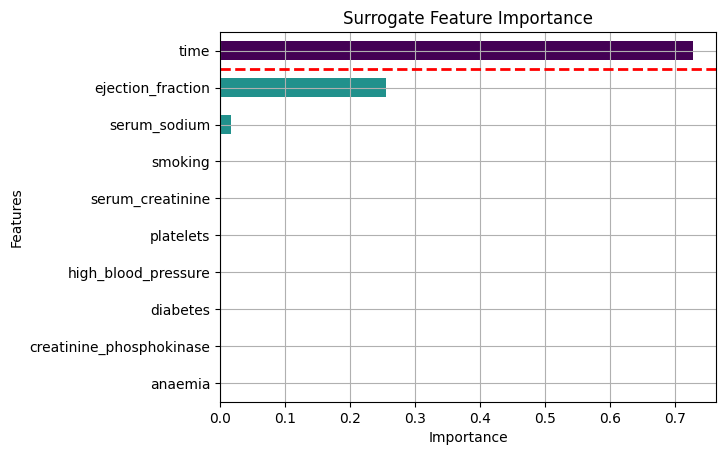

In [11]:
plot_feature_importance(xai_features.feature_importance, xai_features.ranked_feature_importance, top_n=10)

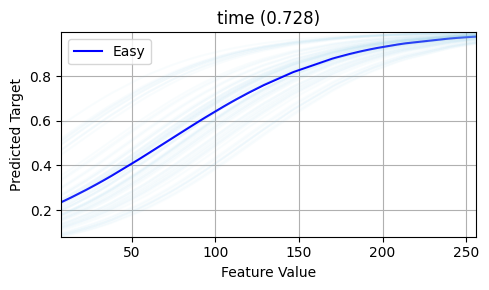

In [12]:
class_index = 0
plot_partial_dependence(xai_features.partial_dependence[class_index], xai_features.ranked_feature_importance, figsize=(5, 3))

### LIME metrics

In [13]:
from holisticai.explainability.commons import LIMEImportanceCalculator

In [14]:
feature_importance_fn = LIMEImportanceCalculator("binary_classification", train['X'], model)

xai_features = classification_explainability_features(test['X'], test['y'], model.predict, model.predict_proba, classes=model.classes_, strategy=feature_importance_fn)

compute_explainability_metrics_from_features(xai_features, metric_type='both')

,value,reference
metric,,
Alpha Importance Score,0.500000,0.0
XAI Ease Score,1.000000,1.0
Position Parity,0.000000,1.0
Rank Alignment,0.040000,1.0
Spread Ratio,0.919072,0.0
Feature Stability,4.071789,0.0
Data Stability,2.089535,0.0


The metrics used to evaluate the feature importance indicates that:

- Alpha importance score: a rasonable number of features have high importance values, suggesting a more even distribution of feature importance.

- XAI ease score: simple, linear relationship between the feature and the predicted outcome. These curves are easy to interpret.

- Position parity: low consistency in the order of feature importance, suggesting variability in model behavior across different groups.

- Rank alignment: low overlap in the top-k feature importance rankings, suggesting variability in the model's feature importance across different groups.

- Spread ratio: distribution of feature importance is far from uniform, suggesting that the model relies on fewer, more significant features. This implies higher interpretability.

- Feature stability: the importance of features is consistent across different features, making the model more interpretable and reliable.

- Data stability: the importance of features is consistent across different instances, making the model more interpretable and reliable.

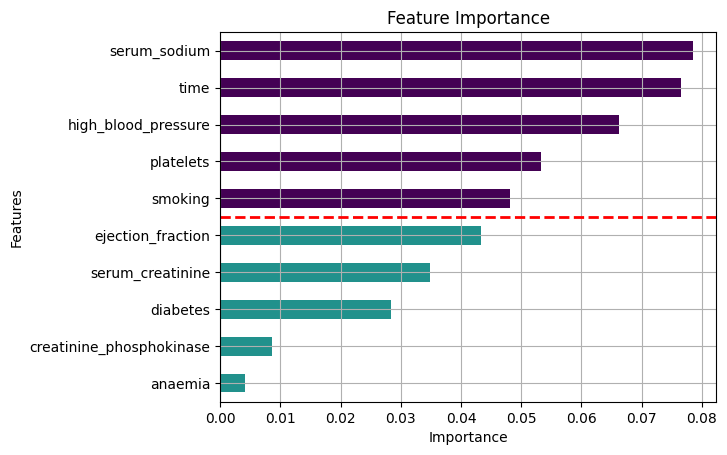

In [15]:
plot_feature_importance(xai_features.feature_importance, xai_features.ranked_feature_importance, top_n=10)

We can observe that the importances in the LIME model are not concentrated in a few features. The top-10 features show serum_sodium, time, high blood pressure, platelets, and smoking as the most important features. This is different from the permutation and surrogate feature importance, which showed time and ejection fraction as the most important features.

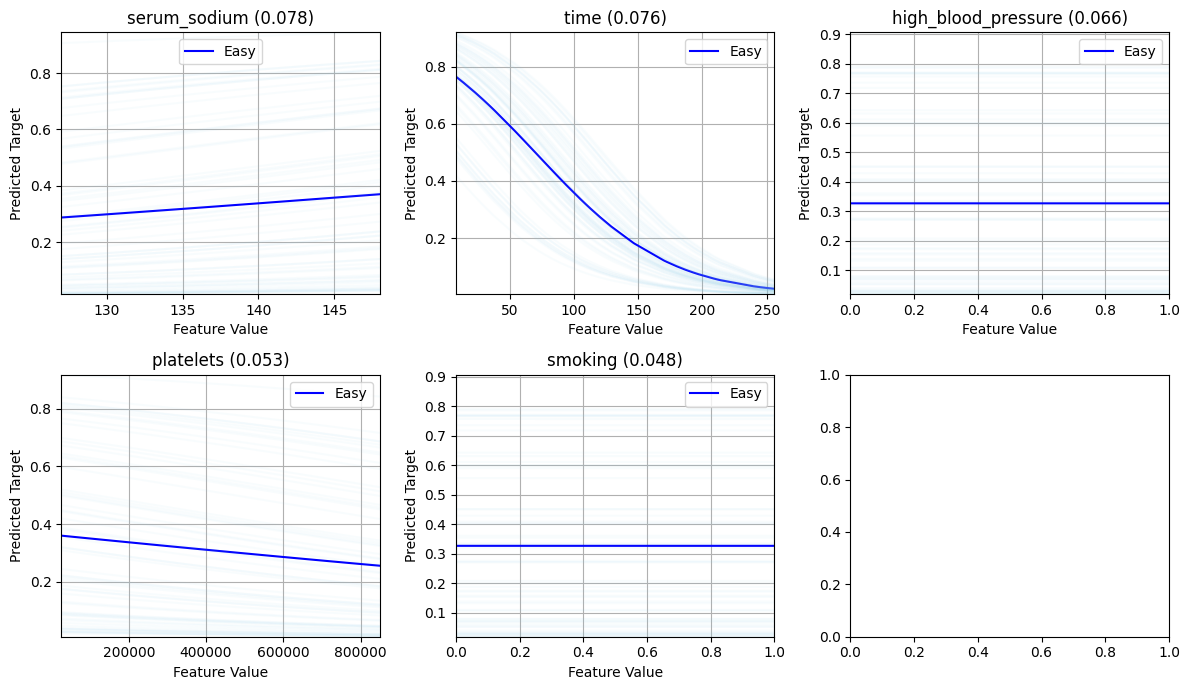

In [16]:
class_index = 1 #1
plot_partial_dependence(xai_features.partial_dependence[class_index], xai_features.ranked_feature_importance, subplots=(2,3), figsize=(12, 7))

Partial dependence plot show that the model has a linear relationship between the feature and the predicted outcome. This indicates that the model is easy to interpret and understand.

### SHAP metrics

In [17]:
from holisticai.explainability.commons import SHAPImportanceCalculator

In [18]:
feature_importance_fn = SHAPImportanceCalculator(train['X'], model)

xai_features = classification_explainability_features(test['X'], test['y'], model.predict, model.predict_proba, classes=model.classes_, strategy=feature_importance_fn)

compute_explainability_metrics_from_features(xai_features, metric_type='both')

,value,reference
metric,,
Alpha Importance Score,0.100000,0.0
XAI Ease Score,1.000000,1.0
Position Parity,0.000000,1.0
Rank Alignment,0.000000,1.0
Spread Ratio,0.372363,0.0
Feature Stability,inf,0.0
Data Stability,9.987292,0.0


The metrics used to evaluate the feature importance based on SHAP values is close to the LIME, except for the spread ratio. The spread ratio is lower for SHAP.

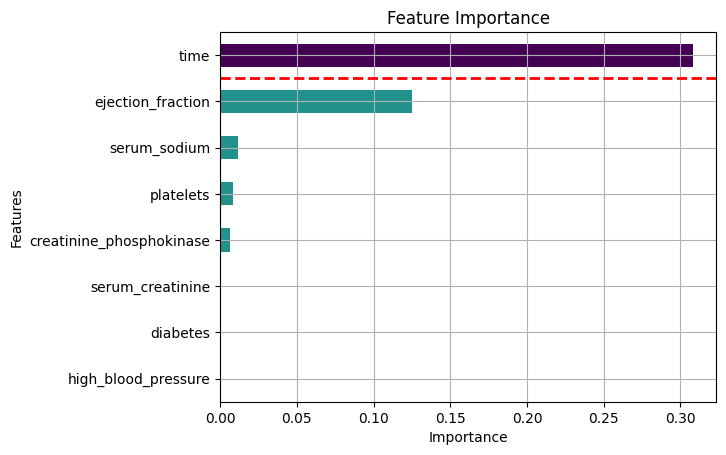

In [19]:
plot_feature_importance(xai_features.feature_importance, xai_features.ranked_feature_importance, top_n=8)

By analyzing the SHAP summary plot, we can observe that the most important features are time and ejection fraction, which are consistent with the permutation feature importance and surrogate importance.

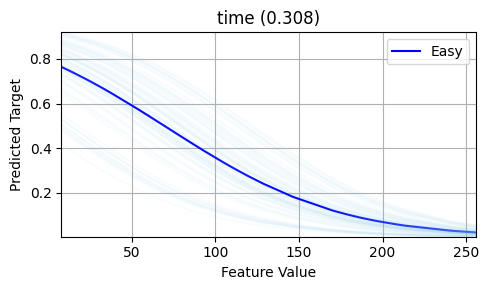

In [20]:
class_index = 1 #1
plot_partial_dependence(xai_features.partial_dependence[class_index], xai_features.ranked_feature_importance, figsize=(5, 3))

Partial dependence plot also show that the model has a linear relationship between the feature and the predicted outcome. This indicates that the model is easy to interpret and understand.

## Summary

This case study explored the explainability of a Logistic Regression model trained to predict the survival of heart failure patients. We used a dataset from the UCI Repository, featuring 299 patient records with 10 clinical features.

The analysis revealed that "time" (follow-up period) and "ejection fraction" were identified as the most influential features for predicting survival outcomes, consistently across permutation feature importance, surrogate model analysis, and SHAP metrics. This finding aligns with clinical understanding, where longer follow-up periods allow for better observation of disease progression and the ejection fraction directly reflects the heart's pumping efficiency.

The global explainability metrics highlighted the model's overall simplicity and interpretability. The high XAI ease score, position parity, and rank alignment suggest a straightforward relationship between features and outcomes and consistent model behavior across different patient subgroups. The relatively high spread ratio reinforces this interpretability by indicating that the model primarily relies on a few, highly significant features. While LIME metrics also highlighted the model's simplicity, they pointed to potential variability in feature importance across different subgroups and individual instances. This observation suggests the need for further investigation and potentially, model refinement to ensure consistent and equitable predictions for all patients.

This case study demonstrates the value of explainability metrics in healthcare applications of machine learning. Understanding the model's reasoning process not only strengthens trust in its predictions but also provides valuable insights into the clinical factors driving survival outcomes for heart failure patients.